# Ajuste de modelo SEIR

Ajuste de un modelo SEIR discreto de paso diario a casos observados, y proyección de casos futuros.

## Variables de entrada

### Datos

Los datos a utilizar se descargan de una planilla online. Se indica la dirección web (url) y cuál es la columna que corresponde a los datos de casos para ajustar el modelo.

- Casos Balcarce: https://docs.google.com/spreadsheets/d/e/2PACX-1vRRWrV2K2KCePi2niVxNNQyL_1A2yy6e9HI1CF2ntnPkGVAy4BVRYHfjVcWPKTI-tjC_9UCKd_RA1aV/pub?gid=417658220&single=true&output=csv

- Casos Gral.Pueyrredón: https://docs.google.com/spreadsheets/d/e/2PACX-1vT0hwpAagfQnC7P6zyVMMMcopXfl6WsuiMORVPB5m4GUf8Tetwz34K6kx_E2Q6WpUGyMUWZfk62B0cN/pub?gid=417658220&single=true&output=csv

In [ ]:
# dircción web (url) de la planilla de datos

url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT0hwpAagfQnC7P6zyVMMMcopXfl6WsuiMORVPB5m4GUf8Tetwz34K6kx_E2Q6WpUGyMUWZfk62B0cN/pub?gid=417658220&single=true&output=csv' 

# columna de datos a ajustar
columna_datos = 'estimados_minsal'

### Parámetros

Valores para los parámetros del modelo y otras variables necesarias para las simulaciones: 

- El valor del parámetro R0 es el que se va a ajustar a los datos, por lo que el valor que se indica acá se toma sólo como valor inicial. Los parámetros alpha y gamma son fijos, y el parámetro beta se calcula a partir de R0 y gamma.

- Los parámetros se ajustan para 3 períodos de tiempo de distinta duración, tomando los datos de, por ejemplo, las últimas 1, 2 y 3 semanas. Para asegurar un mejor ajuste, en cada caso se inician las simulaciones unos días antes ('lag') del período a considerar.

- Luego para cada ajuste de parámetros, se realiza una proyección hacia el futuro, una cierta cantidad de días.

In [ ]:
# parámetros del modelo SEIR
R0 = 1.5
alpha = 1 / 3
gamma = 1 / 7
beta = R0 * gamma
# población total
T = 650000

# días que se consideran para realizar el ajuste de parámetros
duracion_ajuste_1 = 21
duracion_ajuste_2 = 14
duracion_ajuste_3 =  7

# cuántos días antes se inicia la simulación para que se 'estabilicen' los valores
duracion_lag = 7

# duración de la proyección
duracion_proyeccion = 16


# Otras configuraciones
Bibliotecas de código que se utilizarán, y configuraciones de estilo de los gráficos

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# estilo para los gráficos
plt.style.use('seaborn-whitegrid')
plt.rcParams['lines.linewidth'] = 4
plt.rcParams["legend.loc"] = 'best'
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["axes.labelsize"] = 8

## Códigos del modelo

### Función para correr el modelo

In [ ]:
def modelo_SEIR(tabla_datos, fila_inicio=0, fila_fin=-1):

    '''
    Modelo SEIR de paso diario

    Variables de entrada:
        tabla_datos: dataframe con (al menos) las siguientes columnas:
            R0: parámetro R0, un valor para cada fila/día
            Alpha: parámetro Alpha, un valor para cada fila/día
            Gamma: parámetro Gamma, un valor para cada fila/día
            Beta: parámetro Beta (se calcula a partir de R0 y Gamma)
            S: individuos susceptibles, valor para fila inicial
            E: individuos expuestos, valor para fila inicial
            I: individuos infectados, valor para fila inicial
            Ia: individuos infectados acumulados, valor para fila inicial
            R: individuos recuperados/removidos, valor para fila inicial
        fila_inicio: fila correspondiente al día 0 de la simulación (default comienza en fila 0)
        fila_fin: fila correspondiente al último día de la simulación (default hasta la última fila)
    
    Salida: mismo dataframe de entrada con los resultados de individuos S, E, I, R, Ia
    '''

    # hacer una copia de los datos (para no modificar la tabla de datos original)
    datos = tabla_datos.copy()

    # si no se ingresa valor de última fila, contar las filas
    if(fila_fin==-1): fila_fin = len(datos.index) - 1

    for d in range(fila_inicio, fila_fin):

        # leer valores dia actual
        S = datos.loc[d,'S']
        E = datos.loc[d,'E']
        I = datos.loc[d,'I']
        R = datos.loc[d,'R']
        T = S+I+R

        # leer parámetros día actual
        R0 = datos.loc[d,'R0']
        alpha = datos.loc[d,'Alpha']
        gamma = datos.loc[d,'Gamma']
        
        # calcular Beta a partir del R0 y escribirlo en la tabla
        beta = R0 * gamma
        datos.loc[d, 'Beta'] = beta
        
        # calcular valores día siguiente
        S1 = S - beta * S * I/T
        E1 = E + beta * S * I/T - alpha * E
        I1 = I + alpha * E + - gamma * I
        R1 = R + I * gamma
        Ia1 = I1 + R1

        # escribir datos día siguiente
        datos.loc[d+1,'S'] = S1
        datos.loc[d+1,'E'] = E1
        datos.loc[d+1,'I'] = I1
        datos.loc[d+1,'R'] = R1
        datos.loc[d+1,'Ia'] = Ia1

    # resultado
    return datos

### Función para ajustar el modelo

Función que ajusta los parámetros del modelo, minimizando la diferencia entre valores observados y simulados.

In [ ]:
import random
from sklearn.metrics import mean_squared_error
from math import sqrt

def ajustar_modelo(modelo, datos, serie_estimados, serie_observados, inicio_ajuste=0, fin_ajuste=-1, variacion_aleatoria=0.05, maximo_iteraciones=1000, maximo_iteraciones_sin_cambios=150):

    '''
    Función para ajustar parámetros de modelos SEIR de paso diario
    Variables de entrada:
    modelo                          función del modelo a ejecutar
    datos                           tabla de datos con las variables de entrada del modelo
    serie_estimados                 nombre de la serie que contiene los datos estimados por el modelo 
    serie_observados                nombre de la serie que contiene los datos observados
    inicio_ajuste                   fila a partir de la cual se comparan observado y estimado (por defecto la primera fila)
    fin_ajuste                      fila a hasta la cual se comparan observado y estimado (por defecto la última fila)
    variacion_aleatoria             proporción en la que se varían los parámetros en cada iteración
    maximo_iteraciones              cantidad máxima de iteraciones
    maximo_iteraciones_sin_cambios  cantidad de iteraciones sin cambios para considerar ajustado el modelo
    '''

    # hacer una copia de los datos de entrada
    ajuste_preliminar = datos.copy()
    # contar la cantidad de datos observados disponibles
    cantidad_datos = ajuste_preliminar[serie_observados].count()
    ultima_fila = cantidad_datos - 1
    # chequear si se ingresó un valor para la última fila a considerar para el ajuste
    if(fin_ajuste==-1): fin_ajuste=ultima_fila
    # valor inicial rmse
    mejor_rmse = -1
    
    # iterar para mejorar el ajuste, hasta el valor máximo permitido
    for i in range(maximo_iteraciones):

        # correr el modelo para la tabla completa
        ajuste_preliminar = modelo(ajuste_preliminar, 0, ultima_fila)

        # calcular RMSE para el período de ajuste (desde inicio_ajuste hasta fin_ajuste)
        datos_estimados  = ajuste_preliminar.loc[inicio_ajuste:fin_ajuste, serie_estimados]
        datos_observados = ajuste_preliminar.loc[inicio_ajuste:fin_ajuste, serie_observados]
        rmse = sqrt(mean_squared_error(datos_estimados, datos_observados))

        # verificar si el RMSE mejoró (o si es la primera iteración)
        if(rmse<mejor_rmse or i==0): # and minima_diferencia>=0):
            mejor_rmse = rmse
            mejor_ajuste = ajuste_preliminar.copy()
            iteraciones_sin_cambios = 0

        # si no, volver al mejor ajuste anterior
        else:
            ajuste_preliminar = mejor_ajuste.copy()
            iteraciones_sin_cambios = iteraciones_sin_cambios + 1

        # aleatorizar los parámetros para una nueva iteración
        aleatorizar_parametros(ajuste_preliminar, variacion_aleatoria)

        # mostrar progreso
        if(i % 100)==0:
            print(".", end=" ")

        # si ya hubo muchas iteraciones sin que haya cambios, terminar el ajuste
        if(iteraciones_sin_cambios > maximo_iteraciones_sin_cambios): break

    # devolver como resultado el mejor mejor_ajuste obtenido
    return mejor_ajuste


def aleatorizar_parametros(datos, variacion_aleatoria):

    # leer los valores actuales de los parámetros
    R0  = datos.loc[0,'R0']
    S   = datos.loc[0,'S']
    E   = datos.loc[0,'E']
    I   = datos.loc[0,'I']
    Ia  = datos.loc[0,'Ia']
    R   = datos.loc[0,'R']
    T   = S + E + I + R
    
    # aleatorizar el parámetro R0
    multiplicador = random.uniform(1-variacion_aleatoria, 1+variacion_aleatoria)
    R0  = R0  * multiplicador

    # aleatorizar los valores de E e I
    multiplicador = random.uniform(1-variacion_aleatoria, 1+variacion_aleatoria)
    E  = E  * multiplicador
    I  = I  * multiplicador

    # aleatorizar el valor de R
    multiplicador = random.uniform(1-variacion_aleatoria, 1+variacion_aleatoria)
    R = R * multiplicador
    
    # recalcular el resto de las variables iniciales
    Ia = R + I
    S = T - E - I - R

    # actualizar los valores en la planilla de datos
    datos['R0']        = R0
    datos.loc[0, 'S']  = S
    datos.loc[0, 'E']  = E
    datos.loc[0, 'I']  = I
    datos.loc[0, 'Ia'] = Ia
    datos.loc[0, 'R']  = R

## Datos

Descargar la planilla de datos y graficarlos.

         fecha  confirmados  activos  estimados_minsal  demora_confirmacion
0   2020-03-12            1        1               NaN                  NaN
1   2020-03-13            1        1               NaN                  NaN
2   2020-03-14            1        1               NaN                  NaN
3   2020-03-15            1        1               NaN                  NaN
4   2020-03-16            1        1               NaN                  NaN
..         ...          ...      ...               ...                  ...
199 2020-09-27        11833     3265           12972.0                 3.28
200 2020-09-28        12189     3418           13421.0                 3.61
201 2020-09-29        12511     3413           13839.0                 3.62
202 2020-09-30        12862     3461           14193.0                 3.63
203 2020-10-01        13239     3463           14572.0                 3.64

[204 rows x 5 columns]


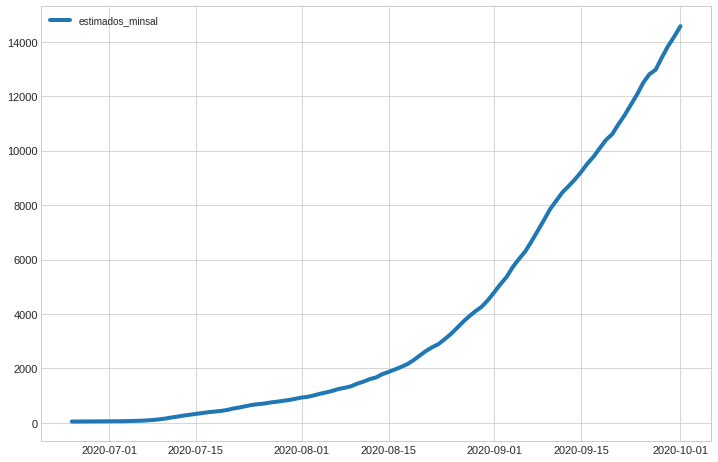

In [ ]:
plt.figure(figsize=(12, 8))

# leer planilla desde url y leer primera columna (0) como fecha 
datos = pd.read_csv(url, parse_dates=[0])

# graficar datos
plt.plot(datos['fecha'],datos[columna_datos], label=columna_datos)
plt.legend(loc='upper left')

# mostrar tabla de datos
print(datos)


## Ajuste de parámetros

### Ajuste para el primer período

In [ ]:
# recortar la tabla de datos y dejar sólo las filas que se van a usar para el ajuste
filas = duracion_lag + duracion_ajuste_1 + 1
datos_ajuste = datos.tail(filas).reset_index(drop=True)

# agregar columnas para los parámetros del modelo, e incluir los valores iniciales en todas las filas
## valores de R0 y Beta a partir de los resultados del ajuste con nexo/sin nexo
datos_ajuste['R0']    = R0
datos_ajuste['Alpha'] = alpha
datos_ajuste['Beta']  = beta
datos_ajuste['Gamma'] = gamma

# estimar valores iniciales de casos expuestos y activos
casos_primera_semana = datos_ajuste.loc[7, columna_datos] - datos_ajuste.loc[0, columna_datos]
I = casos_primera_semana
E = I * gamma / alpha

# tomar valores iniciales de casos acumulados
Ia  = datos_ajuste.loc[0, columna_datos]
R = Ia - I
S = T - E - I - R

# agregar columnas para los compartimientos del modelo y los valores iniciales en la primera fila
datos_ajuste.loc[0, 'S']     = S
datos_ajuste.loc[0, 'E']     = E
datos_ajuste.loc[0, 'I']     = I
datos_ajuste.loc[0, 'Ia']    = Ia
datos_ajuste.loc[0, 'R']     = R

# correr la función de ajuste de parámetros
resultado_ajuste_1 = ajustar_modelo(modelo_SEIR, datos_ajuste, 'Ia', columna_datos, duracion_lag, variacion_aleatoria=0.05)

# mostrar R0 ajustado
print('R0 ajustado:',resultado_ajuste_1.loc[0,'R0'])

datos_ajuste.head()

. . . . R0 ajustado: 1.0213472267491073


,fecha,confirmados,activos,estimados_minsal,demora_confirmacion,R0,Alpha,Beta,Gamma,S,E,I,Ia,R
0,2020-09-03,4357,1729,5357.0,3.78,1.5,0.333333,0.214286,0.142857,643575.428571,1067.571429,2491.0,5357.0,2866.0
1,2020-09-04,4622,1850,5723.0,4.06,1.5,0.333333,0.214286,0.142857,NaN,NaN,NaN,NaN,NaN
2,2020-09-05,4929,1987,6021.0,3.99,1.5,0.333333,0.214286,0.142857,NaN,NaN,NaN,NaN,NaN
3,2020-09-06,5168,2069,6295.0,3.83,1.5,0.333333,0.214286,0.142857,NaN,NaN,NaN,NaN,NaN
4,2020-09-07,5348,2153,6658.0,3.99,1.5,0.333333,0.214286,0.142857,NaN,NaN,NaN,NaN,NaN


### Ajuste para el segundo período

In [ ]:
# recortar la tabla de datos y dejar sólo las filas que se van a usar para el ajuste
filas = duracion_lag + duracion_ajuste_2 + 1
datos_ajuste = resultado_ajuste_1.tail(filas).reset_index(drop=True)

# correr la función de ajuste de parámetros
resultado_ajuste_2 = ajustar_modelo(modelo_SEIR, datos_ajuste, 'Ia', columna_datos, duracion_lag, variacion_aleatoria=0.05)

# mostrar R0 ajustado
print('R0 ajustado:',resultado_ajuste_2.loc[0,'R0'])

. . . . . . R0 ajustado: 1.1647306320378061


### Ajuste para el tercer período

In [ ]:
# recortar la tabla de datos y dejar sólo las filas que se van a usar para el ajuste
filas = duracion_lag + duracion_ajuste_3 + 1
datos_ajuste = resultado_ajuste_2.tail(filas).reset_index(drop=True)

# correr la función de ajuste de parámetros
resultado_ajuste_3 = ajustar_modelo(modelo_SEIR, datos_ajuste, 'Ia', columna_datos, duracion_lag, variacion_aleatoria=0.05)

# mostrar R0 ajustado
print('R0 ajustado:',resultado_ajuste_3.loc[0,'R0'])

. . . . . . R0 ajustado: 1.2138250291842487


### Resultado

Graficar el resultado de los 3 ajustes en comparación con los datos observados

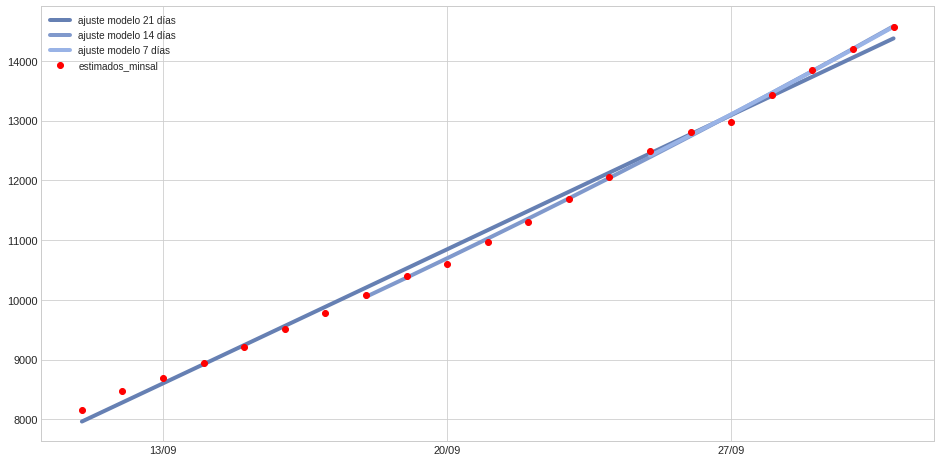

In [ ]:
plt.figure(figsize=(16, 8))

# casos estimados
plt.plot(
    resultado_ajuste_1['fecha'].tail(duracion_ajuste_1),
    resultado_ajuste_1['Ia'].tail(duracion_ajuste_1), 
    '-', 
    color=[0.4,0.5,0.7],
    label='ajuste modelo '+str(duracion_ajuste_1)+' días')
plt.plot(
    resultado_ajuste_2['fecha'].tail(duracion_ajuste_2),
    resultado_ajuste_2['Ia'].tail(duracion_ajuste_2), 
    '-', 
    color=[0.5,0.6,0.8],
    label='ajuste modelo '+str(duracion_ajuste_2)+' días')
plt.plot(
    resultado_ajuste_3['fecha'].tail(duracion_ajuste_3),
    resultado_ajuste_3['Ia'].tail(duracion_ajuste_3), 
    '-', 
    color=[0.6,0.7,0.9],
    label='ajuste modelo '+str(duracion_ajuste_3)+' días')
# casos observados
plt.plot(
    resultado_ajuste_1['fecha'].tail(duracion_ajuste_1),
    resultado_ajuste_1[columna_datos].tail(duracion_ajuste_1), 
    'o', color='red', label=columna_datos)

# ubicación leyeda
plt.legend(loc='upper left')
# formato de fecha
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# escala semanal
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(6))

## Proyecciones

### Proyección simple

In [ ]:
# copiar columnas de datos de la tabla de resultados del ajuste
datos_simulacion_1 = resultado_ajuste_1.tail(duracion_ajuste_1).reset_index(drop=True)
datos_simulacion_2 = resultado_ajuste_2.tail(duracion_ajuste_2).reset_index(drop=True)
datos_simulacion_3 = resultado_ajuste_3.tail(duracion_ajuste_3).reset_index(drop=True)

# función para agregar filas con los días subsiguientes para la proyección del modelo
def armar_tabla_proyeccion(datos_simulacion, duracion_proyeccion):

    for i in range(duracion_proyeccion):
        ultima_fila = datos_simulacion.index.max()
        ultima_fecha = datos_simulacion.loc[ultima_fila, 'fecha']
        datos_simulacion.loc[ultima_fila + 1, 'fecha'] = ultima_fecha + pd.Timedelta(days=1)

    # agregar columnas para los parámetros del modelo, e incluir los valores iniciales en todas las filas
    datos_simulacion['R0']    = datos_simulacion.loc[0, 'R0']
    datos_simulacion['Alpha'] = datos_simulacion.loc[0, 'Alpha']
    datos_simulacion['Beta']  = datos_simulacion.loc[0, 'Beta']
    datos_simulacion['Gamma'] = datos_simulacion.loc[0, 'Gamma']

# llamar a la función para los 3 períodos
armar_tabla_proyeccion(datos_simulacion_1, duracion_proyeccion)
armar_tabla_proyeccion(datos_simulacion_2, duracion_proyeccion)
armar_tabla_proyeccion(datos_simulacion_3, duracion_proyeccion)

# correr las 3 simulaciones
resultado_simulacion_1 = modelo_SEIR(datos_simulacion_1)
resultado_simulacion_2 = modelo_SEIR(datos_simulacion_2)
resultado_simulacion_3 = modelo_SEIR(datos_simulacion_3)

### Resultado

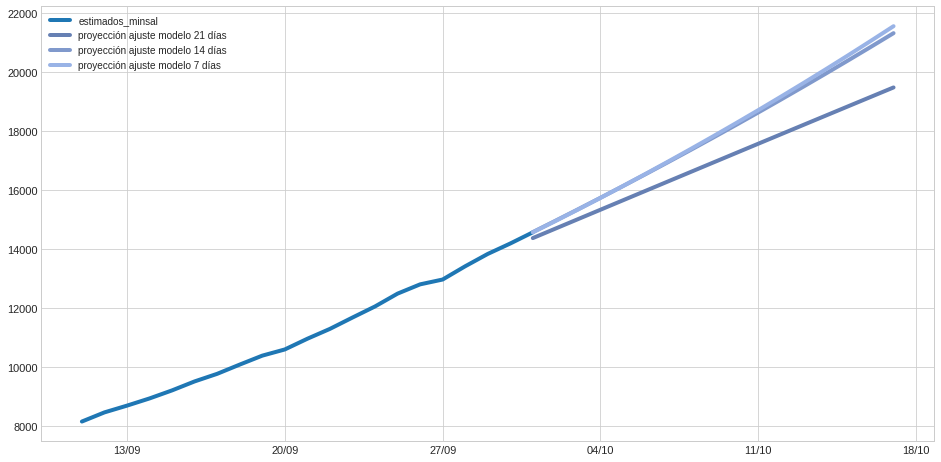

In [ ]:
plt.figure(figsize=(16, 8))

# casos observados
plt.plot(
    resultado_simulacion_1['fecha'],
    resultado_simulacion_1[columna_datos], 
    '-', 
    label=columna_datos)

# casos estimados
plt.plot(
    resultado_simulacion_1['fecha'].tail(duracion_proyeccion + 1),
    resultado_simulacion_1['Ia'].tail(duracion_proyeccion + 1), 
    '-', 
    color=[0.4,0.5,0.7],
    label='proyección ajuste modelo '+str(duracion_ajuste_1)+' días')
plt.plot(
    resultado_simulacion_2['fecha'].tail(duracion_proyeccion + 1),
    resultado_simulacion_2['Ia'].tail(duracion_proyeccion + 1), 
    '-', 
    color=[0.5,0.6,0.8],
    label='proyección ajuste modelo '+str(duracion_ajuste_2)+' días')
plt.plot(
    resultado_simulacion_3['fecha'].tail(duracion_proyeccion + 1),
    resultado_simulacion_3['Ia'].tail(duracion_proyeccion + 1), 
    '-', 
    color=[0.6,0.7,0.9],
    label='proyección ajuste modelo '+str(duracion_ajuste_3)+' días')

# ubicación leyeda
plt.legend(loc='upper left')
# formato de fecha
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# escala semanal
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(6))

### Corrección por demora entre apertura y confirmación

In [ ]:
def extender_datos_demora(datos):
    # recorrer toda la columna de datos
    for i, fila in datos.iterrows():
        demora = datos.loc[i, 'demora_confirmacion']
        # si el dato es 'NaN' (celda vacía), copiar el valor anterior
        if demora!=demora:
           demora = datos.loc[i-1, 'demora_confirmacion']
           datos.loc[i, 'demora_confirmacion'] = demora
        # transformar el número en días en formato de fecha 'timedelta' (td)
        datos.loc[i, 'demora_confirmacion_td'] = pd.Timedelta(days=demora)

extender_datos_demora(resultado_simulacion_1)
extender_datos_demora(resultado_simulacion_2)
extender_datos_demora(resultado_simulacion_3)

resultado_simulacion_1['fecha_confirmacion'] = resultado_simulacion_1['fecha'] + resultado_simulacion_1['demora_confirmacion_td']
resultado_simulacion_2['fecha_confirmacion'] = resultado_simulacion_2['fecha'] + resultado_simulacion_2['demora_confirmacion_td']
resultado_simulacion_3['fecha_confirmacion'] = resultado_simulacion_3['fecha'] + resultado_simulacion_3['demora_confirmacion_td']

(737679.0, 737715.0)

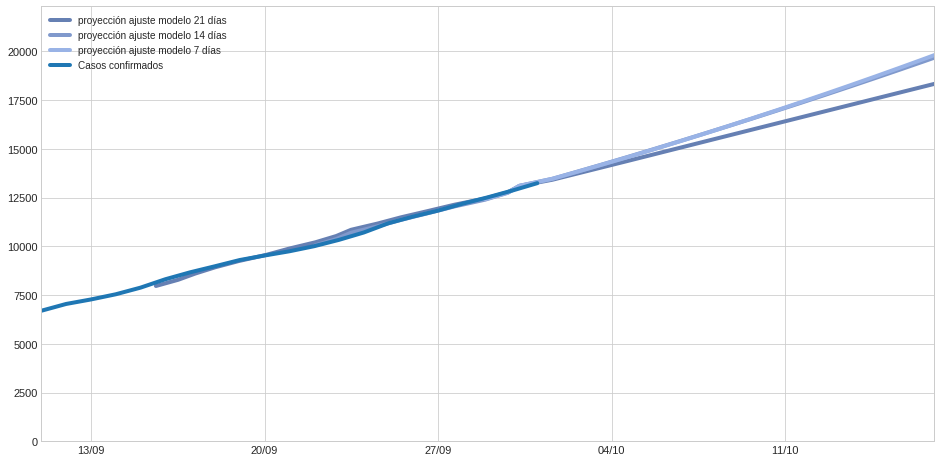

In [ ]:
plt.figure(figsize=(16, 8))

# casos estimados
plt.plot(
    resultado_simulacion_1['fecha_confirmacion'],
    resultado_simulacion_1['Ia'], 
    '-', 
    color=[0.4,0.5,0.7],
    label='proyección ajuste modelo '+str(duracion_ajuste_1)+' días')
plt.plot(
    resultado_simulacion_2['fecha_confirmacion'],
    resultado_simulacion_2['Ia'], 
    '-', 
    color=[0.5,0.6,0.8],
    label='proyección ajuste modelo '+str(duracion_ajuste_2)+' días')
plt.plot(
    resultado_simulacion_3['fecha_confirmacion'],
    resultado_simulacion_3['Ia'], 
    '-', 
    color=[0.6,0.7,0.9],
    label='proyección ajuste modelo '+str(duracion_ajuste_3)+' días')


# casos confirmados
plt.plot(
    resultado_simulacion_1['fecha'],
    resultado_simulacion_1['confirmados'], 
    '-', 
    label='Casos confirmados')


# ubicación leyeda
plt.legend(loc='upper left')
# formato de fecha
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# escala semanal
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(6))
# escala ejes x e y
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left =resultado_simulacion_1['fecha'].iloc[ 0])
plt.gca().set_xlim(right=resultado_simulacion_1['fecha'].iloc[-1])

## Intervalo de variación

### Identificar ajuste máximo y mínimo

In [ ]:
# ver los valores de casos estimados finales en cada simulación
ultima_fila = len(resultado_simulacion_1.index) -1
valor_final_simulacion_1 = resultado_simulacion_1.loc[ultima_fila,'Ia']
ultima_fila = len(resultado_simulacion_2.index) -1
valor_final_simulacion_2 = resultado_simulacion_2.loc[ultima_fila,'Ia']
ultima_fila = len(resultado_simulacion_3.index) -1
valor_final_simulacion_3 = resultado_simulacion_3.loc[ultima_fila,'Ia']

# calcular máximo y mínimo
maximo = max([valor_final_simulacion_1, valor_final_simulacion_2, valor_final_simulacion_3])
minimo = min([valor_final_simulacion_1, valor_final_simulacion_2, valor_final_simulacion_3])

# identificar cuál simulación es la que da el valor máximo
if valor_final_simulacion_1 == maximo: maximo_proyeccion = resultado_simulacion_1.copy()
if valor_final_simulacion_2 == maximo: maximo_proyeccion = resultado_simulacion_2.copy()
if valor_final_simulacion_3 == maximo: maximo_proyeccion = resultado_simulacion_3.copy()

# identificar cuál simulación es la que da el valor mínimo
if valor_final_simulacion_1 == minimo: minimo_proyeccion = resultado_simulacion_1.copy()
if valor_final_simulacion_2 == minimo: minimo_proyeccion = resultado_simulacion_2.copy()
if valor_final_simulacion_3 == minimo: minimo_proyeccion = resultado_simulacion_3.copy()

# recortar las tablas para que tengan la misma duración, y que inicien donde terminan los datos observados
demora = round(resultado_simulacion_1.loc[-1:,'demora_confirmacion'].mean())
maximo_proyeccion = maximo_proyeccion.tail(duracion_proyeccion + demora + 2).reset_index(drop=True)
minimo_proyeccion = minimo_proyeccion.tail(duracion_proyeccion + demora + 2).reset_index(drop=True)

(737679.0, 737715.0)

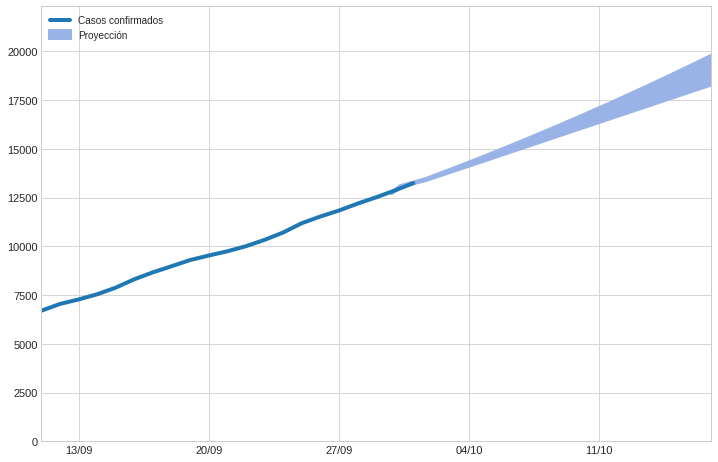

In [ ]:
plt.figure(figsize=(12, 8))
# casos confirmados
plt.plot(
    resultado_simulacion_1['fecha'],
    resultado_simulacion_1['confirmados'], 
    '-', 
    label='Casos confirmados')

# casos estimados
plt.fill_between(
    maximo_proyeccion['fecha_confirmacion'],
    minimo_proyeccion['Ia'], 
    maximo_proyeccion['Ia'], 
    color=[0.6,0.7,0.9],
    lw=4,
    label='Proyección')

# ubicación leyeda
plt.legend(loc='upper left')
# formato de fecha
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# escala semanal
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(6))
# escala ejes x e y
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left =resultado_simulacion_1['fecha'].iloc[ 0])
plt.gca().set_xlim(right=resultado_simulacion_1['fecha'].iloc[-1])

### Variar demora

Hacer que el intervalor entre apertura del caso y confirmación aumente o disminuya

(737679.0, 737715.0)

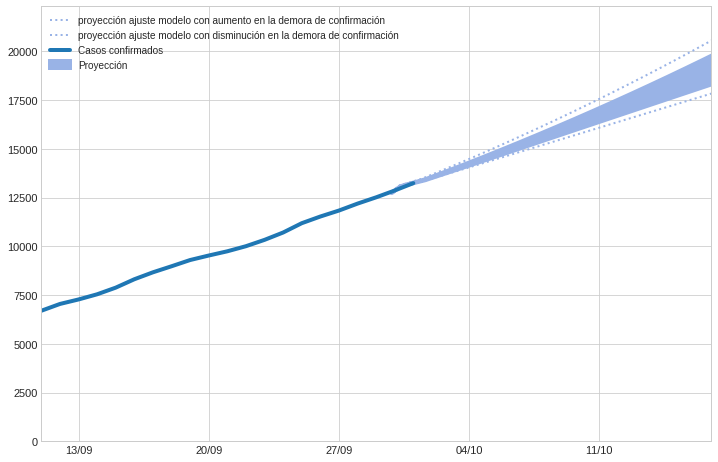

In [ ]:
plt.figure(figsize=(12, 8))

demora_maxima = 6
demora_minima = 2
demora_inicial = minimo_proyeccion.loc[0, 'demora_confirmacion']

filas = len(maximo_proyeccion.index)
for f in range(filas):

    aumento_demora     = f / filas * (demora_maxima - demora_inicial)
    maximo_proyeccion.loc[f, 'fecha_aumento_demora']     = maximo_proyeccion.loc[f, 'fecha_confirmacion'] + pd.Timedelta(days=aumento_demora)
    minimo_proyeccion.loc[f, 'fecha_aumento_demora']     = minimo_proyeccion.loc[f, 'fecha_confirmacion'] + pd.Timedelta(days=aumento_demora)
    
    disminucion_demora = f / filas * (demora_minima - demora_inicial)
    maximo_proyeccion.loc[f, 'fecha_disminucion_demora'] = maximo_proyeccion.loc[f, 'fecha_confirmacion'] + pd.Timedelta(days=disminucion_demora)
    minimo_proyeccion.loc[f, 'fecha_disminucion_demora'] = minimo_proyeccion.loc[f, 'fecha_confirmacion'] + pd.Timedelta(days=disminucion_demora)

# casos estimados proyección R0 actual
plt.fill_between(
    maximo_proyeccion['fecha_confirmacion'],
    minimo_proyeccion['Ia'], 
    maximo_proyeccion['Ia'], 
    color=[0.6,0.7,0.9],
    lw=4,
    label='Proyección')

# casos estimados con distinta demora
plt.plot(
    minimo_proyeccion['fecha_aumento_demora'],
    minimo_proyeccion['Ia'], 
    ':', 
    lw=2,
    color=[0.6,0.7,0.9],
    label='proyección ajuste modelo con aumento en la demora de confirmación')
plt.plot(
    maximo_proyeccion['fecha_disminucion_demora'],
    maximo_proyeccion['Ia'], 
    ':', 
    lw=2,
    color=[0.6,0.7,0.9],
    label='proyección ajuste modelo con disminución en la demora de confirmación')

# casos confirmados
plt.plot(
    resultado_simulacion_1['fecha'],
    resultado_simulacion_1['confirmados'], 
    '-', 
    label='Casos confirmados')

# ubicación leyeda
plt.legend(loc='upper left')
# formato de fecha
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# escala semanal
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(6))
# escala ejes x e y
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left =resultado_simulacion_1['fecha'].iloc[ 0])
plt.gca().set_xlim(right=resultado_simulacion_1['fecha'].iloc[-1])

### Variar R0

Aumentar el R0 para el valor máximo y disminuirlo para el valor mínimo, un % fijo.

In [ ]:
maximo_proyeccion_mayor_R0          = maximo_proyeccion.copy()
maximo_proyeccion_mayor_R0['R0']    = maximo_proyeccion.loc[0,'R0'] * 1.15
maximo_proyeccion_mayor_R0          = modelo_SEIR(maximo_proyeccion_mayor_R0)

minimo_proyeccion_menor_R0          = minimo_proyeccion.copy()
minimo_proyeccion_menor_R0['R0']    = minimo_proyeccion.loc[0,'R0'] * 0.85
minimo_proyeccion_menor_R0          = modelo_SEIR(minimo_proyeccion_menor_R0)

(737679.0, 737715.0)

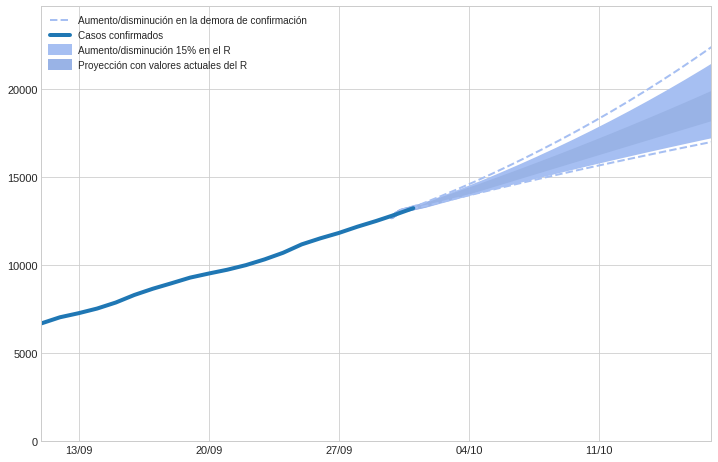

In [ ]:
plt.figure(figsize=(12, 8))

# casos estimados variando demora y variando R0
plt.plot(
    minimo_proyeccion_menor_R0['fecha_aumento_demora'],
    minimo_proyeccion_menor_R0['Ia'], 
    '--', 
    lw=2,
    color=[0.65,0.75,0.95],
    label='Aumento/disminución en la demora de confirmación')
plt.plot(
    maximo_proyeccion_mayor_R0['fecha_disminucion_demora'],
    maximo_proyeccion_mayor_R0['Ia'], 
    '--', 
    lw=2,
    color=[0.65,0.75,0.95])

# casos estimados variando R0
plt.fill_between(
    maximo_proyeccion['fecha_confirmacion'],
    minimo_proyeccion_menor_R0['Ia'], 
    maximo_proyeccion_mayor_R0['Ia'], 
    color=[0.65,0.75,0.95],
    lw=4,
    label='Aumento/disminución 15% en el R')

# casos estimados proyección R0 actual
plt.fill_between(
    maximo_proyeccion['fecha_confirmacion'],
    minimo_proyeccion['Ia'], 
    maximo_proyeccion['Ia'], 
    color=[0.6,0.7,0.9],
    lw=4,
    label='Proyección con valores actuales del R')

# casos confirmados
plt.plot(
    resultado_simulacion_1['fecha'],
    resultado_simulacion_1['confirmados'], 
    '-', 
    label='Casos confirmados')
    
# ubicación leyeda
plt.legend(loc='upper left')
# formato de fecha
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# escala semanal
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(6))
# escala ejes x e y
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left =resultado_simulacion_1['fecha'].iloc[ 0])
plt.gca().set_xlim(right=resultado_simulacion_1['fecha'].iloc[-1])

### Aumentar el R0 para el valor máximo y disminuirlo para el valor mínimo, un % diario.

In [ ]:
filas = len(maximo_proyeccion.index)
variacion_diaria = 0.015

R0 = maximo_proyeccion.loc[0,'R0']
maximo_proyeccion_aumento_R0          = maximo_proyeccion.copy()
maximo_proyeccion_aumento_R0['R0']    = ( 1 + pd.Series(range(filas)) * variacion_diaria ) * R0
maximo_proyeccion_aumento_R0          = modelo_SEIR(maximo_proyeccion_aumento_R0)

R0 = minimo_proyeccion.loc[0,'R0']
minimo_proyeccion_disminucion_R0          = minimo_proyeccion.copy()
minimo_proyeccion_disminucion_R0['R0']    = ( 1 - pd.Series(range(filas)) * variacion_diaria ) * R0
minimo_proyeccion_disminucion_R0          = modelo_SEIR(minimo_proyeccion_disminucion_R0)

(737679.0, 737715.0)

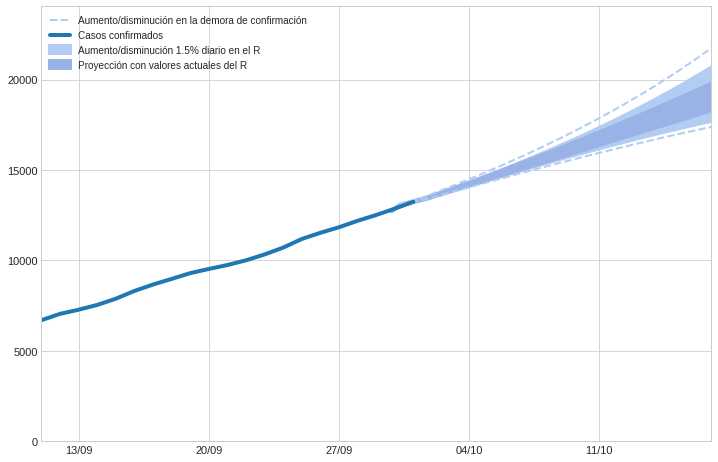

In [ ]:
plt.figure(figsize=(12, 8))

# casos estimados variando demora y variando R0
plt.plot(
    minimo_proyeccion_disminucion_R0['fecha_aumento_demora'],
    minimo_proyeccion_disminucion_R0['Ia'], 
    '--', 
    lw=2,
    color=[0.7,0.8,0.95],
    label='Aumento/disminución en la demora de confirmación')
plt.plot(
    maximo_proyeccion_aumento_R0['fecha_disminucion_demora'],
    maximo_proyeccion_aumento_R0['Ia'], 
    '--', 
    lw=2,
    color=[0.7,0.8,0.95])

# casos estimados variando R0
plt.fill_between(
    maximo_proyeccion['fecha_confirmacion'],
    minimo_proyeccion_disminucion_R0['Ia'], 
    maximo_proyeccion_aumento_R0['Ia'], 
    color=[0.7,0.8,0.95],
    lw=4,
    label='Aumento/disminución ' + str(variacion_diaria*100) + '% diario en el R')

# casos estimados proyección R0 actual
plt.fill_between(
    maximo_proyeccion['fecha_confirmacion'],
    minimo_proyeccion['Ia'], 
    maximo_proyeccion['Ia'], 
    color=[0.6,0.7,0.9],
    lw=4,
    label='Proyección con valores actuales del R')

# casos confirmados
plt.plot(
    resultado_simulacion_1['fecha'],
    resultado_simulacion_1['confirmados'], 
    '-', 
    label='Casos confirmados')
    
# ubicación leyenda
plt.legend(loc='upper left')
# formato de fecha
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# escala semanal
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(6))
# escala ejes x e y
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left =resultado_simulacion_1['fecha'].iloc[ 0])
plt.gca().set_xlim(right=resultado_simulacion_1['fecha'].iloc[-1])

### Figura para informe

Text(1.0, 0, 'Elaboración: Gustavo Pereyra Irujo - Luciano Velázquez | FCA-UNMDP/INTA/CONICET')

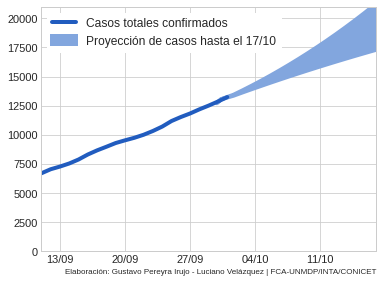

In [ ]:
plt.figure(figsize=(6, 4.5))

fecha_fin_proyeccion = resultado_simulacion_1['fecha'].dt.strftime('%d/%m').iloc[-1]

# casos estimados variando R0
plt.fill_between(
    minimo_proyeccion['fecha_confirmacion'],
    minimo_proyeccion_menor_R0['Ia'], 
    maximo_proyeccion_mayor_R0['Ia'], 
    color=[0.51,0.65,0.87],
    lw=4,
    label='Proyección de casos hasta el ' + str(fecha_fin_proyeccion))

# casos confirmados
plt.plot(
    resultado_simulacion_1['fecha'],
    resultado_simulacion_1['confirmados'], 
    '-', 
    color=[0.13,0.36,0.75],
    label='Casos totales confirmados')
    
# ubicación leyenda
plt.legend(loc='upper left', fontsize=12, frameon=True, facecolor='white', edgecolor='white', framealpha=1)
# formato de fecha
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# escala semanal
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(6))
# escala ejes x e y
plt.gca().set_ylim(bottom=0)
plt.gca().set_ylim(top=21000)
plt.gca().set_xlim(left =resultado_simulacion_1['fecha'].iloc[ 0])
plt.gca().set_xlim(right=resultado_simulacion_1['fecha'].iloc[-1])
# leyenda
plt.xlabel('Elaboración: Gustavo Pereyra Irujo - Luciano Velázquez | FCA-UNMDP/INTA/CONICET', horizontalalignment='right', x=1.0)



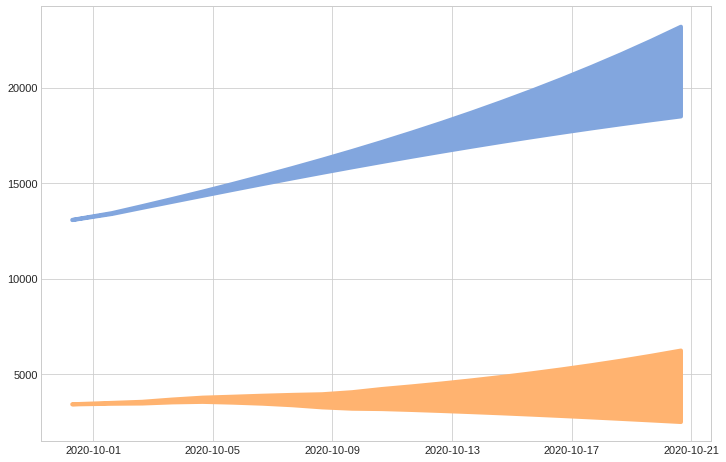

In [ ]:
plt.figure(figsize=(12, 8))

# hacer series de datos uniendo los casos confirmados y la proyección
proyeccion_completa = pd.DataFrame(columns=['fecha', 'totales_maximo', 'totales_minimo', 'activos_maximo', 'activos_minimo'])

proyeccion_completa['fecha'] = datos['fecha']
proyeccion_completa['totales_minimo'] = datos['estimados_minsal']
proyeccion_completa['totales_maximo'] = datos['estimados_minsal']

# contar la cantidad de filas hasta la fecha en que comienzan las proyecciones
primera_fecha_proyecciones = minimo_proyeccion_menor_R0.loc[0, 'fecha']
cantidad_datos_minsal = datos['fecha'].count()
ultima_fila = -1
for f in range(cantidad_datos_minsal):
    fecha_minsal = datos.loc[f, 'fecha']
    if fecha_minsal < primera_fecha_proyecciones:
        ultima_fila = ultima_fila + 1

# luego agregar los casos proyectados
cantidad_datos_proyectados = minimo_proyeccion_menor_R0['Ia'].count()
for f in range(cantidad_datos_proyectados):
    ultima_fila = ultima_fila + 1
    proyeccion_completa.loc[ultima_fila, 'fecha']          = minimo_proyeccion_menor_R0.loc[f, 'fecha']
    proyeccion_completa.loc[ultima_fila, 'totales_minimo'] = int(minimo_proyeccion_disminucion_R0.loc[f, 'Ia'])
    proyeccion_completa.loc[ultima_fila, 'totales_maximo'] = int(maximo_proyeccion_aumento_R0.loc[f, 'Ia'])

# calcular activos
dias_alta_min = 14 - demora
dias_alta_max = 15 - demora
proyeccion_completa['activos_minimo'] = (proyeccion_completa['totales_minimo'].diff(periods=dias_alta_min) + proyeccion_completa['totales_minimo'].diff(periods=dias_alta_max)) /2
proyeccion_completa['activos_maximo'] = (proyeccion_completa['totales_maximo'].diff(periods=dias_alta_min) + proyeccion_completa['totales_maximo'].diff(periods=dias_alta_max)) /2

# recortar la tabla de datos para que coincida con las proyecciones
cantidad_filas_proyeccion = len(resultado_simulacion_1)
proyeccion_completa = proyeccion_completa.tail(cantidad_filas_proyeccion).reset_index(drop=True)

# agregar fecha corregida por demora en confirmación
proyeccion_completa['fecha_confirmacion'] = resultado_simulacion_1['fecha_confirmacion']

# recortar la tabla
proyeccion_completa = proyeccion_completa.tail(duracion_proyeccion + demora + 1).reset_index(drop=True)

plt.fill_between(
    proyeccion_completa['fecha_confirmacion'],
    proyeccion_completa['totales_minimo'], 
    proyeccion_completa['totales_maximo'], 
    color=[0.51,0.65,0.87],
    lw=4,
    label='Proyección de casos hasta el ' + str(fecha_fin_proyeccion))

plt.fill_between(
    proyeccion_completa['fecha_confirmacion'],
    proyeccion_completa['activos_minimo'], 
    proyeccion_completa['activos_maximo'], 
    color=[1.00,0.70,0.44],
    lw=4,
    label='Proyección de casos hasta el ' + str(fecha_fin_proyeccion))

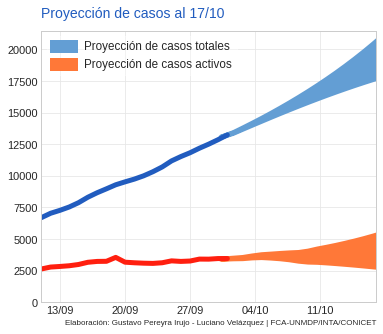

In [ ]:
plt.figure(figsize=(6, 5))

fecha_fin_proyeccion = resultado_simulacion_1['fecha'].dt.strftime('%d/%m').iloc[-1]

# casos estimados variando R0
plt.fill_between(
    proyeccion_completa['fecha_confirmacion'],
    proyeccion_completa['totales_minimo'], 
    proyeccion_completa['totales_maximo'], 
    color=[0.39,0.62,0.83],
    lw=5,
    label='Proyección de casos totales')

# casos confirmados
plt.plot(
    resultado_simulacion_1['fecha'],
    resultado_simulacion_1['confirmados'], 
    '-', 
    lw=5,
    color=[0.13,0.36,0.75])

# casos activos estimados variando R0
plt.fill_between(
    proyeccion_completa['fecha_confirmacion'],
    proyeccion_completa['activos_minimo'], 
    proyeccion_completa['activos_maximo'], 
    color=[1.00,0.47,0.22],
    lw=5,
    label='Proyección de casos activos')

# casos activos
plt.plot(
    resultado_simulacion_1['fecha'],
    resultado_simulacion_1['activos'], 
    '-', 
    lw=5,
    color=[1.00,0.12,0.06])

ax = plt.gca()
#color_fondo = [0.86,0.86,0.87]
color_fondo = [1,1,1]
ax.set_facecolor(color_fondo)
# color grilla
ax.grid(color=[0.9,0.9,0.9])
# ubicación leyenda
plt.legend(loc='upper left', fontsize=11.6, frameon=True, 
           facecolor=color_fondo, edgecolor=color_fondo, framealpha=0.4)
# formato de fecha
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# escala semanal
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(6))
# escala ejes x e y
plt.gca().set_ylim(bottom=0)
plt.gca().set_ylim(top=21500)
plt.gca().set_xlim(left =resultado_simulacion_1['fecha'].iloc[ 0])
plt.gca().set_xlim(right=resultado_simulacion_1['fecha'].iloc[-1])
# leyenda
plt.xlabel('Elaboración: Gustavo Pereyra Irujo - Luciano Velázquez | FCA-UNMDP/INTA/CONICET', horizontalalignment='right', x=1.0)
plt.title('Proyección de casos al ' + str(fecha_fin_proyeccion), 
          fontsize=14, color=[0.13,0.36,0.75], horizontalalignment='left', x=0.0, y=1.025)
# guardar imagen
plt.savefig('proyeccion_02oct.png', dpi=150)

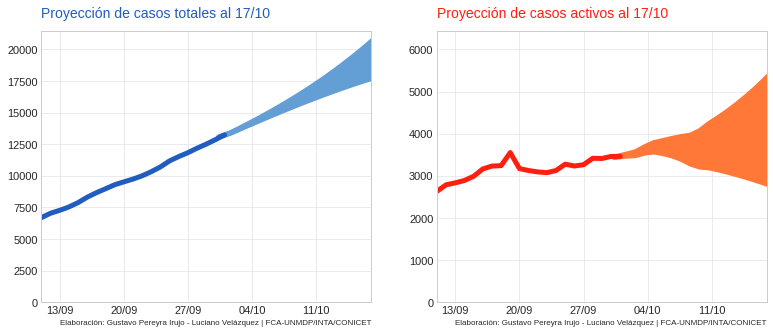

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(13, 5))

fecha_fin_proyeccion = resultado_simulacion_1['fecha'].dt.strftime('%d/%m').iloc[-1]

# figura casos totales
ax1 = axes[0]

# casos estimados variando R0
ax1.fill_between(
    proyeccion_completa['fecha_confirmacion'],
    proyeccion_completa['totales_minimo'], 
    proyeccion_completa['totales_maximo'], 
    color=[0.39,0.62,0.83],
    lw=5)

# casos confirmados
ax1.plot(
    resultado_simulacion_1['fecha'],
    resultado_simulacion_1['confirmados'], 
    '-', 
    lw=5,
    color=[0.13,0.36,0.75])

# figura casos activos
ax2 = axes[1]

# casos activos estimados variando R0
ax2.fill_between(
    proyeccion_completa['fecha_confirmacion'],
    proyeccion_completa['activos_minimo'], 
    proyeccion_completa['activos_maximo'], 
    color=[1.00,0.47,0.22],
    lw=5)

# casos activos
ax2.plot(
    resultado_simulacion_1['fecha'],
    resultado_simulacion_1['activos'], 
    '-', 
    lw=5,
    color=[1.00,0.12,0.06])

#color_fondo = [0.86,0.86,0.87]
color_fondo = [1,1,1]
ax1.set_facecolor(color_fondo)
ax2.set_facecolor(color_fondo)
# color grilla
ax1.grid(color=[0.9,0.9,0.9])
ax2.grid(color=[0.9,0.9,0.9])
# formato de fecha
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# escala semanal
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(6))
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(6))
# escala ejes x e y
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax1.set_ylim(top=21500)
ax2.set_ylim(top=6000*21500/20000)
ax1.set_xlim(left =resultado_simulacion_1['fecha'].iloc[ 0])
ax2.set_xlim(left =resultado_simulacion_1['fecha'].iloc[ 0])
ax1.set_xlim(right=resultado_simulacion_1['fecha'].iloc[-1])
ax2.set_xlim(right=resultado_simulacion_1['fecha'].iloc[-1])
# leyenda
ax1.set_xlabel('Elaboración: Gustavo Pereyra Irujo - Luciano Velázquez | FCA-UNMDP/INTA/CONICET', horizontalalignment='right', x=1.0)
ax2.set_xlabel('Elaboración: Gustavo Pereyra Irujo - Luciano Velázquez | FCA-UNMDP/INTA/CONICET', horizontalalignment='right', x=1.0)
ax1.set_title('Proyección de casos totales al ' + str(fecha_fin_proyeccion), 
          fontsize=14, color=[0.13,0.36,0.75], horizontalalignment='left', x=0.0, y=1.025)
ax2.set_title('Proyección de casos activos al ' + str(fecha_fin_proyeccion), 
          fontsize=14, color=[1.00,0.12,0.06], horizontalalignment='left', x=0.0, y=1.025) 
# guardar imagen
plt.savefig('proyeccion_02oct_totales_activos.png', dpi=150)

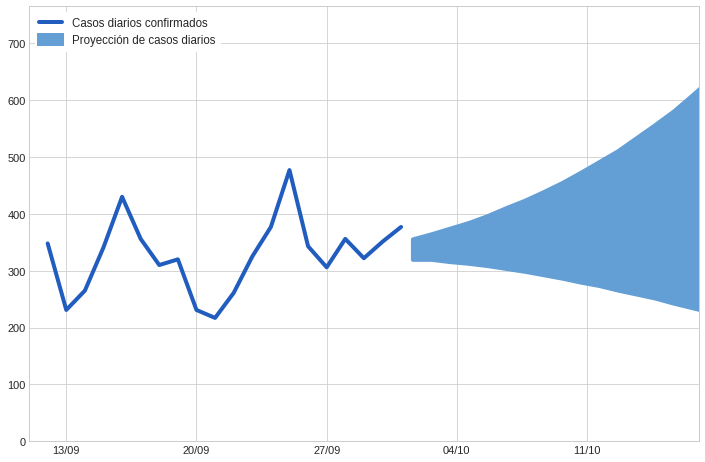

In [ ]:
plt.figure(figsize=(12, 8))

fecha_fin_proyeccion = resultado_simulacion_1['fecha'].dt.strftime('%d/%m').iloc[-1]

# casos estimados variando R0
plt.fill_between(
    proyeccion_completa['fecha_confirmacion'],
    proyeccion_completa['totales_minimo'].diff(), 
    proyeccion_completa['totales_maximo'].diff(), 
    color=[0.39,0.62,0.83],
    lw=4,
    label='Proyección de casos diarios')

# casos confirmados
plt.plot(
    resultado_simulacion_1['fecha'],
    resultado_simulacion_1['confirmados'].diff(), 
    '-', 
    color=[0.13,0.36,0.75],
    label='Casos diarios confirmados')


ax = plt.gca()
#color_fondo = [0.86,0.86,0.87]
color_fondo = [1,1,1]
ax.set_facecolor(color_fondo)
# ubicación leyenda
plt.legend(loc='upper left', fontsize=11.5, frameon=True, facecolor=color_fondo, edgecolor=color_fondo, framealpha=1)
# formato de fecha
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# escala semanal
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(6))
# escala ejes x e y
plt.gca().set_ylim(bottom=0)
#plt.gca().set_ylim(top=14000)
plt.gca().set_xlim(left =resultado_simulacion_1['fecha'].iloc[ 0])
plt.gca().set_xlim(right=resultado_simulacion_1['fecha'].iloc[-1])

# guardar imagen
plt.savefig('proyeccion_02oct_diarios.png', dpi=150)

In [ ]:
print(proyeccion_completa[['fecha_confirmacion', 'totales_minimo', 'totales_maximo']])

    fecha_confirmacion  totales_minimo  totales_maximo
0  2020-09-30 06:43:12         13093.0         13105.0
1  2020-10-01 14:38:24         13413.0         13461.0
2  2020-10-02 14:52:48         13733.0         13826.0
3  2020-10-03 15:07:12         14049.0         14201.0
4  2020-10-04 15:21:36         14362.0         14586.0
5  2020-10-05 15:21:36         14671.0         14983.0
6  2020-10-06 15:21:36         14975.0         15394.0
7  2020-10-07 15:21:36         15274.0         15818.0
8  2020-10-08 15:21:36         15567.0         16257.0
9  2020-10-09 15:21:36         15854.0         16712.0
10 2020-10-10 15:21:36         16134.0         17185.0
11 2020-10-11 15:21:36         16408.0         17677.0
12 2020-10-12 15:21:36         16674.0         18188.0
13 2020-10-13 15:21:36         16933.0         18722.0
14 2020-10-14 15:21:36         17185.0         19279.0
15 2020-10-15 15:21:36         17428.0         19860.0
16 2020-10-16 15:21:36         17663.0         20469.0
17 2020-10

In [ ]:
carpeta_destino = '/content/drive/My Drive/COVID Zona VIII/'
datos.to_csv(carpeta_destino + 'datos.csv', index = False)
resultado_ajuste_1.to_csv(carpeta_destino + 'resultado_ajuste_1.csv', index = False)
resultado_ajuste_2.to_csv(carpeta_destino + 'resultado_ajuste_2.csv', index = False)
resultado_ajuste_3.to_csv(carpeta_destino + 'resultado_ajuste_3.csv', index = False)


FileNotFoundError: ignored